<a href="https://colab.research.google.com/github/alinetabatta/fall-detection/blob/main/Assign3_Fall_Detection_AC0_92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To simplify, divide each set (training and testing) into separate folders. In each folder, group the fall class examples into one folder and the non-fall class examples into another ✅

Within each file for each class, identify the best way to extract features from the accelerometer (X, Y, and Z), gyroscope (X, Y, and Z), and magnetometer (X, Y, and Z) signals and create a training and testing database containing only the features for each fall and non-fall (ADL) example✅

In [ ]:
import zipfile
import os
import pandas as pd
from PIL import Image
import io
from google.colab import drive
import os
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

train_data_path = '/content/drive/MyDrive/Data Fall Detection/train_data'
test_data_path = '/content/drive/MyDrive/Data Fall Detection/test_data'

# Function to create folders by the prefix
def organize_files_by_category(folder_path):
    non_falls_folder = os.path.join(folder_path, 'non_falls')
    falls_folder = os.path.join(folder_path, 'falls')



    os.makedirs(non_falls_folder, exist_ok=True)
    os.makedirs(falls_folder, exist_ok=True)


    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            if filename.startswith('1'):
                shutil.move(file_path, os.path.join(non_falls_folder, filename))
            elif filename.startswith('2'):
                shutil.move(file_path, os.path.join(falls_folder, filename))


    print(f"Arquivos de {folder_path} organizados em:")
    print(f" - 📁 {non_falls_folder}")
    print(f" - 📁 {falls_folder}")


organize_files_by_category(train_data_path)
organize_files_by_category(test_data_path)



Arquivos de /content/drive/MyDrive/Data Fall Detection/train_data organizados em:
 - 📁 /content/drive/MyDrive/Data Fall Detection/train_data/non_falls
 - 📁 /content/drive/MyDrive/Data Fall Detection/train_data/falls
Arquivos de /content/drive/MyDrive/Data Fall Detection/test_data organizados em:
 - 📁 /content/drive/MyDrive/Data Fall Detection/test_data/non_falls
 - 📁 /content/drive/MyDrive/Data Fall Detection/test_data/falls


The next code will create some plots of fall and non-fall data to analyse some patterns and create features based on some signal patterns

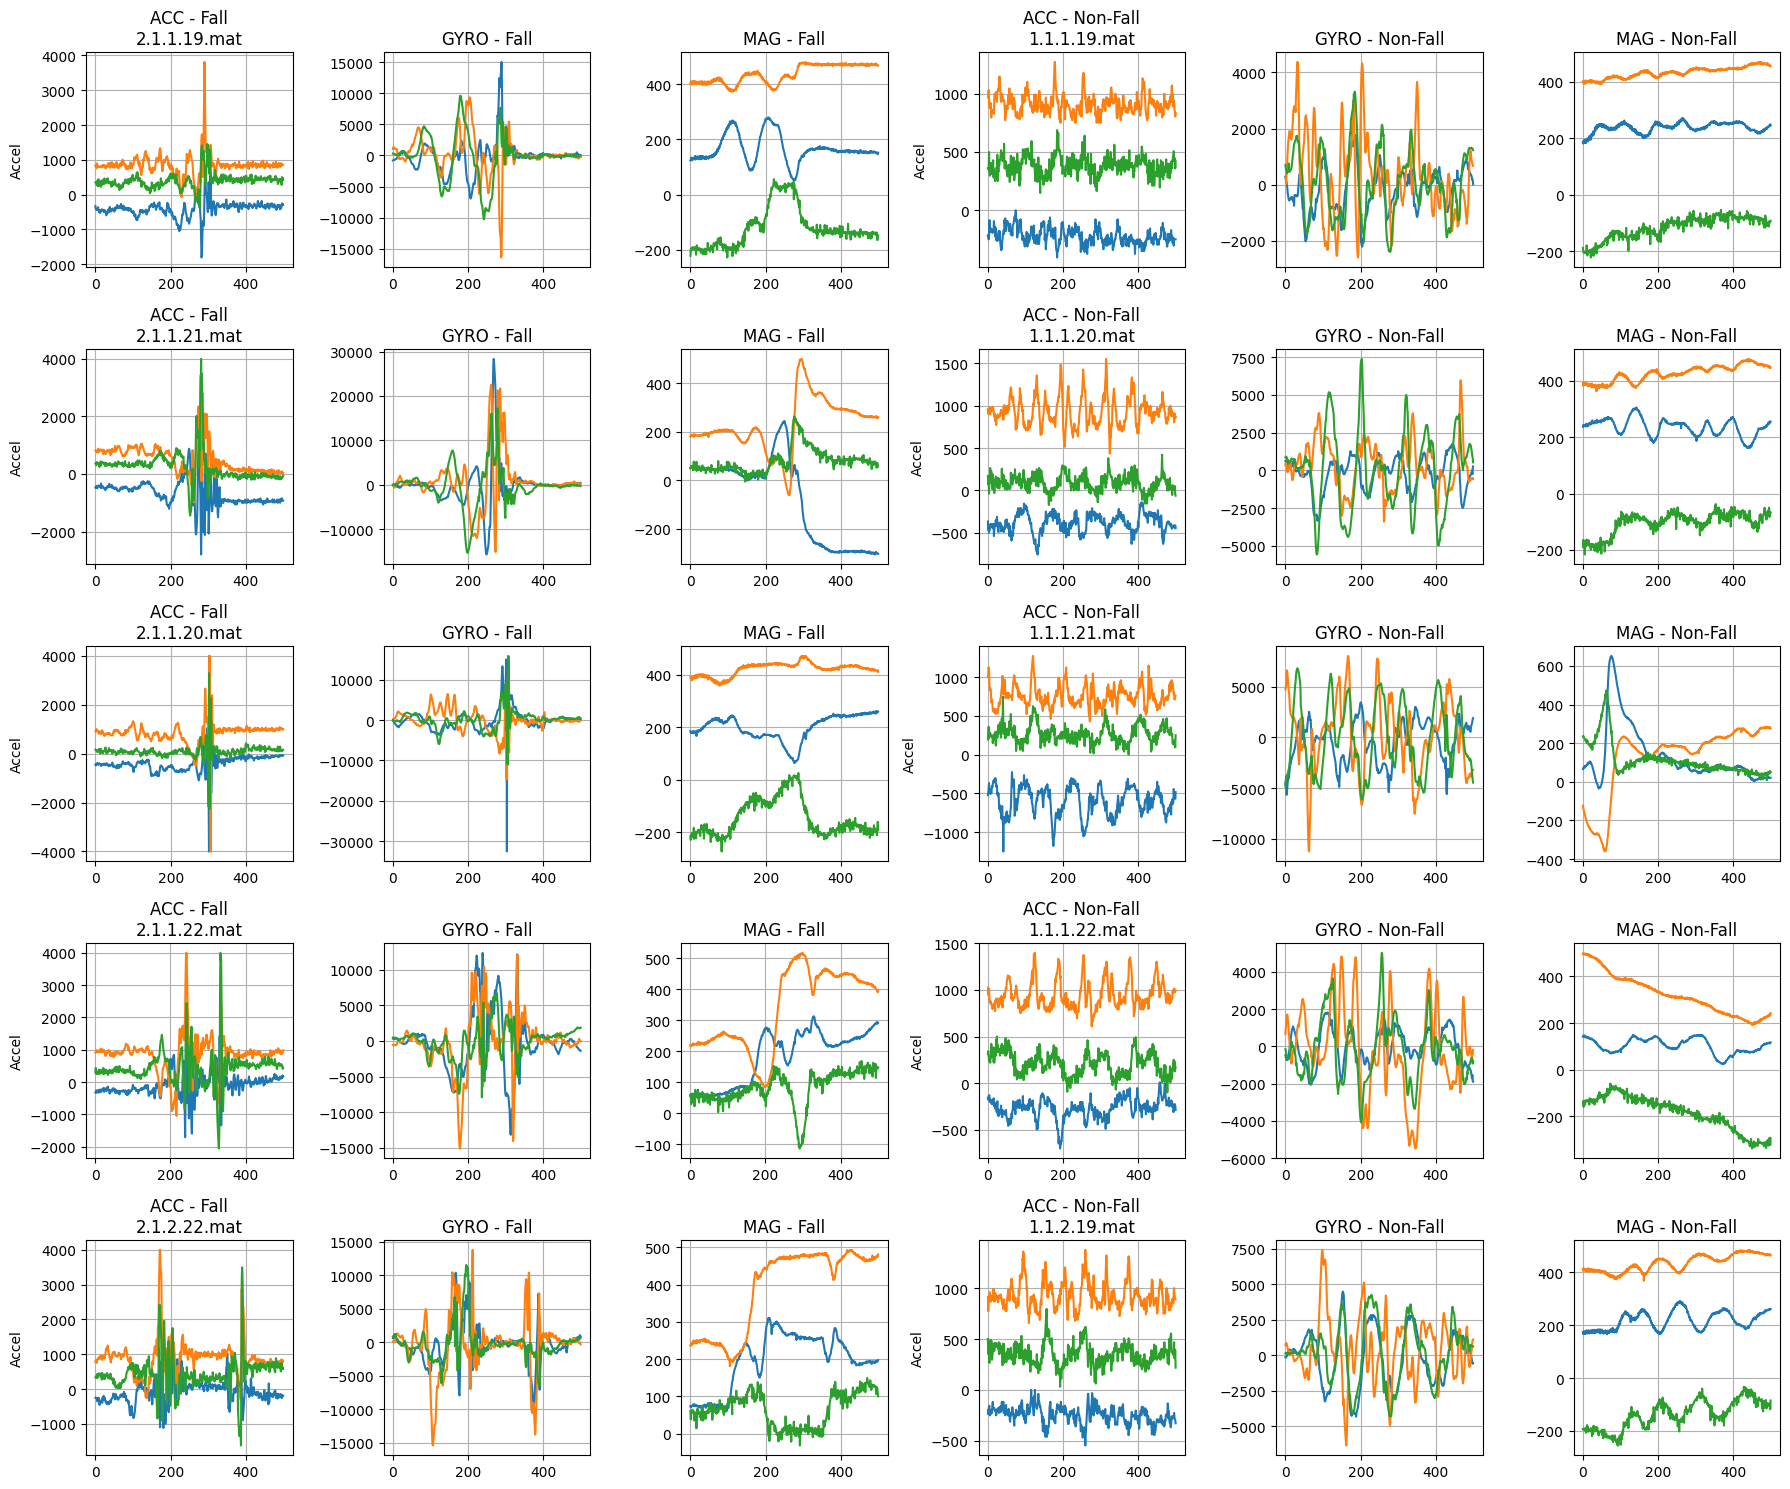

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


def read_mat_data(filepath):
    mat = loadmat(filepath)
    if 'newData' in mat:
        data = mat['newData']
        if data.ndim == 2 and data.shape[1] >= 11:
            return data
        else:
            raise ValueError(f"'newData' não tem a estrutura esperada em {filepath}")
    else:
        raise KeyError(f"'newData' não encontrado em {filepath}")


falls_dir = os.path.join(train_data_path, 'falls')
non_falls_dir = os.path.join(train_data_path, 'non_falls')


falls_files = [f for f in os.listdir(falls_dir) if f.endswith('.mat')]
non_falls_files = [f for f in os.listdir(non_falls_dir) if f.endswith('.mat')]


selected_falls = falls_files[:5]
selected_non_falls = non_falls_files[:5]


plt.figure(figsize=(18, 15))

for i, filename in enumerate(selected_falls):
    filepath = os.path.join(falls_dir, filename)
    data = read_mat_data(filepath)

    acc = data[:, 1:4]
    gyro = data[:, 4:7]
    mag = data[:, 7:10]

    plt.subplot(5, 6, 6*i + 1)
    plt.plot(acc)
    plt.title(f'ACC - Fall\n{filename}')
    plt.ylabel('Accel')
    plt.grid(True)

    plt.subplot(5, 6, 6*i + 2)
    plt.plot(gyro)
    plt.title(f'GYRO - Fall')
    plt.grid(True)

    plt.subplot(5, 6, 6*i + 3)
    plt.plot(mag)
    plt.title(f'MAG - Fall')
    plt.grid(True)

for i, filename in enumerate(selected_non_falls):
    filepath = os.path.join(non_falls_dir, filename)
    data = read_mat_data(filepath)

    acc = data[:, 1:4]
    gyro = data[:, 4:7]
    mag = data[:, 7:10]

    plt.subplot(5, 6, 6*i + 4)
    plt.plot(acc)
    plt.title(f'ACC - Non-Fall\n{filename}')
    plt.ylabel('Accel')
    plt.grid(True)

    plt.subplot(5, 6, 6*i + 5)
    plt.plot(gyro)
    plt.title(f'GYRO - Non-Fall')
    plt.grid(True)

    plt.subplot(5, 6, 6*i + 6)
    plt.plot(mag)
    plt.title(f'MAG - Non-Fall')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import fft
from scipy.signal import find_peaks
import math


train_data_path = '/content/drive/MyDrive/Data Fall Detection/train_data'
output_csv_path = '/content/drive/MyDrive/Data Fall Detection/features_dataset.csv'

# === FEATURE FUNCTIONS ===
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

def dominant_frequency(signal, fs=50):
    spectrum = np.abs(fft(signal))
    freq = np.fft.fftfreq(len(signal), d=1/fs)
    positive_freqs = freq[:len(freq)//2]
    positive_spectrum = spectrum[:len(freq)//2]
    return positive_freqs[np.argmax(positive_spectrum)]

def spectral_energy(signal):
    spectrum = np.abs(fft(signal))
    energy = np.sum(spectrum**2) / len(spectrum)
    return energy


def compute_euler_angles(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):

    roll = np.arctan2(acc_y, acc_z)
    pitch = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))

    mag_x_comp = mag_x * np.cos(pitch) + mag_z * np.sin(pitch)
    mag_y_comp = mag_x * np.sin(roll) * np.sin(pitch) + mag_y * np.cos(roll) - mag_z * np.sin(roll) * np.cos(pitch)
    yaw = np.arctan2(-mag_y_comp, mag_x_comp)


    return np.rad2deg(roll), np.rad2deg(pitch), np.rad2deg(yaw)





# === READ FUNCTION ===
def read_mat_data(filepath):
    mat = loadmat(filepath)
    if 'newData' in mat:
        data = mat['newData']
        return data[:, 1:10]  # Skip time, use acc (1-3), gyro (4-6), mag (7-9)
    else:
        raise KeyError(f"'newData' not found in {filepath}")

# === FEATURE EXTRACTOR ===
def extract_features(data):
    features = {}
    sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z','roll','pitch', 'yaw', 'acc_t']
    # sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']
    for i in range(9):
        mean_tmp =  np.mean(data[:, i])
        signal = (data[:, i] - mean_tmp) / np.max(np.abs(data[:, i]))
        label = sensor_labels[i]
        features[f'{label}_mean'] = mean_tmp
        features[f'{label}_max'] = np.max(signal)
        features[f'{label}_min'] = np.min(signal)
        features[f'{label}_std'] = np.std(signal)
        # features[f'{label}_zcr'] = zero_crossing_rate(signal)
        # features[f'{label}_dom_freq'] = dominant_frequency(signal)
        # features[f'{label}_energy'] = spectral_energy(signal)


    acc_x_norm = (data[:, 0] - np.mean(data[:, 0])) / np.max(np.abs(data[:, 0]))
    acc_y_norm = (data[:, 1] - np.mean(data[:, 1])) / np.max(np.abs(data[:, 1]))
    acc_z_norm = (data[:, 2] - np.mean(data[:, 2])) / np.max(np.abs(data[:, 2]))
    mag_x_norm = (data[:, 6] - np.mean(data[:, 6])) / np.max(np.abs(data[:, 6]))
    mag_y_norm = (data[:, 7] - np.mean(data[:, 7])) / np.max(np.abs(data[:, 7]))
    mag_z_norm = (data[:, 8] - np.mean(data[:, 8])) / np.max(np.abs(data[:, 8]))
    gir_x_norm = (data[:, 3] - np.mean(data[:, 3])) / np.max(np.abs(data[:, 3]))
    gir_y_norm = (data[:, 4] - np.mean(data[:, 4])) / np.max(np.abs(data[:, 4]))
    gir_z_norm = (data[:, 5] - np.mean(data[:, 5])) / np.max(np.abs(data[:, 5]))

    roll, pitch, yaw = compute_euler_angles(acc_x_norm, acc_y_norm, acc_z_norm, mag_x_norm,mag_y_norm, mag_z_norm )
    features[f'{sensor_labels[9]}_max'] = np.max(roll)
    features[f'{sensor_labels[10]}_max'] = np.max(pitch)
    features[f'{sensor_labels[11]}_max'] = np.max(yaw)

    features[f'{sensor_labels[-1]}_max'] = np.max(np.sqrt(acc_x_norm**2 + acc_y_norm**2 + acc_z_norm**2))

        # --- ROTATION ---
    gyro_magnitude = np.sqrt(gir_x_norm**2 + gir_y_norm**2 + gir_z_norm**2)
    features['gyro_magnitude_max'] = np.max(gyro_magnitude)
    features['gyro_magnitude_std'] = np.std(gyro_magnitude)

    # --- ACCELERATION VERTICAL ---
    acc_z_abs = np.abs(data[:, 2])
    features['acc_z_peak'] = np.max(acc_z_abs)

    peaks, _ = find_peaks(acc_z_abs, height=1.5)  # ajuste o threshold conforme seus dados
    features['acc_z_high_peaks'] = len(peaks)

    # --- INSTABILIDADE (ORIENTAÇÃO VARIÁVEL) ---
    features['roll_var'] = np.var(roll)
    features['pitch_var'] = np.var(pitch)
    features['yaw_var'] = np.var(yaw)


    return features

# === PROCESS FALL/NON-FALL FILES ===
def process_files(folder, label):
    features_list = []
    files = [f for f in os.listdir(folder) if f.endswith('.mat')]
    for filename in files:
        filepath = os.path.join(folder, filename)
        try:
            data = read_mat_data(filepath)
            feats = extract_features(data)
            feats['label'] = label
            feats['file'] = filename
            features_list.append(feats)
        except Exception as e:
            print(f"⚠️ Error in {filename}: {e}")
    return features_list

# === MAIN PIPELINE ===
falls_folder = os.path.join(train_data_path, 'falls')
non_falls_folder = os.path.join(train_data_path, 'non_falls')

print("Processing falls...")
fall_features = process_files(falls_folder, label=1)
print("Processing non-falls...")
non_fall_features = process_files(non_falls_folder, label=0)


# === SAVE TO CSV ===
all_features = fall_features + non_fall_features
df_features = pd.DataFrame(all_features)
df_features = df_features.drop(columns=['file'])
df_features.to_csv(output_csv_path, index=False)
print(f"✅ Features saved to: {output_csv_path}")



Processing falls...
Processing non-falls...
✅ Features saved to: /content/drive/MyDrive/Data Fall Detection/features_dataset.csv


In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.fft import fft
from scipy.signal import find_peaks


train_data_path = '/content/drive/MyDrive/Data Fall Detection/test_data'
output_csv_path = '/content/drive/MyDrive/Data Fall Detection/test_set_dataset.csv'


# === FEATURE FUNCTIONS ===
def zero_crossing_rate(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

def dominant_frequency(signal, fs=50):
    spectrum = np.abs(fft(signal))
    freq = np.fft.fftfreq(len(signal), d=1/fs)
    positive_freqs = freq[:len(freq)//2]
    positive_spectrum = spectrum[:len(freq)//2]
    return positive_freqs[np.argmax(positive_spectrum)]

def spectral_energy(signal):
    spectrum = np.abs(fft(signal))
    energy = np.sum(spectrum**2) / len(spectrum)
    return energy


def compute_euler_angles(acc_x, acc_y, acc_z, mag_x, mag_y, mag_z):

    roll = np.arctan2(acc_y, acc_z)
    pitch = np.arctan2(-acc_x, np.sqrt(acc_y**2 + acc_z**2))

    mag_x_comp = mag_x * np.cos(pitch) + mag_z * np.sin(pitch)
    mag_y_comp = mag_x * np.sin(roll) * np.sin(pitch) + mag_y * np.cos(roll) - mag_z * np.sin(roll) * np.cos(pitch)
    yaw = np.arctan2(-mag_y_comp, mag_x_comp)

    return np.rad2deg(roll), np.rad2deg(pitch), np.rad2deg(yaw)

# === READ FUNCTION ===
def read_mat_data(filepath):
    mat = loadmat(filepath)
    if 'newData' in mat:
        data = mat['newData']
        return data[:, 1:10]  # Skip time, use acc (1-3), gyro (4-6), mag (7-9)
    else:
        raise KeyError(f"'newData' not found in {filepath}")

# === FEATURE EXTRACTOR ===
def extract_features(data):
    features = {}
    sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z','roll','pitch', 'yaw', 'acc_t']
    # sensor_labels = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z']
    for i in range(9):
        mean_tmp =  np.mean(data[:, i])
        signal = (data[:, i] - mean_tmp) / np.max(np.abs(data[:, i]))
        label = sensor_labels[i]
        features[f'{label}_mean'] = mean_tmp
        features[f'{label}_max'] = np.max(signal)
        features[f'{label}_min'] = np.min(signal)
        features[f'{label}_std'] = np.std(signal)
        # features[f'{label}_zcr'] = zero_crossing_rate(signal)
        # features[f'{label}_dom_freq'] = dominant_frequency(signal)
        # features[f'{label}_energy'] = spectral_energy(signal)

    acc_x_norm = (data[:, 0] - np.mean(data[:, 0])) / np.max(np.abs(data[:, 0]))
    acc_y_norm = (data[:, 1] - np.mean(data[:, 1])) / np.max(np.abs(data[:, 1]))
    acc_z_norm = (data[:, 2] - np.mean(data[:, 2])) / np.max(np.abs(data[:, 2]))
    mag_x_norm = (data[:, 6] - np.mean(data[:, 6])) / np.max(np.abs(data[:, 6]))
    mag_y_norm = (data[:, 7] - np.mean(data[:, 7])) / np.max(np.abs(data[:, 7]))
    mag_z_norm = (data[:, 8] - np.mean(data[:, 8])) / np.max(np.abs(data[:, 8]))
    gir_x_norm = (data[:, 3] - np.mean(data[:, 3])) / np.max(np.abs(data[:, 3]))
    gir_y_norm = (data[:, 4] - np.mean(data[:, 4])) / np.max(np.abs(data[:, 4]))
    gir_z_norm = (data[:, 5] - np.mean(data[:, 5])) / np.max(np.abs(data[:, 5]))

    roll, pitch, yaw = compute_euler_angles(acc_x_norm, acc_y_norm, acc_z_norm, mag_x_norm,mag_y_norm, mag_z_norm )
    features[f'{sensor_labels[9]}_max'] = np.max(roll)
    features[f'{sensor_labels[10]}_max'] = np.max(pitch)
    features[f'{sensor_labels[11]}_max'] = np.max(yaw)

    features[f'{sensor_labels[-1]}_max'] = np.max(np.sqrt(acc_x_norm**2 + acc_y_norm**2 + acc_z_norm**2))

        # --- ROTATION ---
    gyro_magnitude = np.sqrt(gir_x_norm**2 + gir_y_norm**2 + gir_z_norm**2)
    features['gyro_magnitude_max'] = np.max(gyro_magnitude)
    features['gyro_magnitude_std'] = np.std(gyro_magnitude)

    # --- ACCELERATION VERTICAL ---
    acc_z_abs = np.abs(data[:, 2])
    features['acc_z_peak'] = np.max(acc_z_abs)

    peaks, _ = find_peaks(acc_z_abs, height=1.5)  # ajuste o threshold conforme seus dados
    features['acc_z_high_peaks'] = len(peaks)

    # --- INSTABILIDADE (ORIENTAÇÃO VARIÁVEL) ---
    features['roll_var'] = np.var(roll)
    features['pitch_var'] = np.var(pitch)
    features['yaw_var'] = np.var(yaw)


    return features

# === PROCESS FALL/NON-FALL FILES ===
def process_files(folder, label):
    features_list = []
    files = [f for f in os.listdir(folder) if f.endswith('.mat')]
    for filename in files:
        filepath = os.path.join(folder, filename)
        try:
            data = read_mat_data(filepath)
            feats = extract_features(data)
            feats['label'] = label
            feats['file'] = filename
            features_list.append(feats)
        except Exception as e:
            print(f"⚠️ Error in {filename}: {e}")
    return features_list

# === MAIN PIPELINE ===
falls_folder = os.path.join(train_data_path, 'falls')
non_falls_folder = os.path.join(train_data_path, 'non_falls')

print("Processing falls...")
fall_features = process_files(falls_folder, label=1)
print("Processing non-falls...")
non_fall_features = process_files(non_falls_folder, label=0)


# === SAVE TO CSV ===
all_features = fall_features + non_fall_features
df_features = pd.DataFrame(all_features)
df_features = df_features.drop(columns=['file'])

df_features.to_csv(output_csv_path, index=False)
print(f"✅ Features saved to: {output_csv_path}")



Processing falls...
Processing non-falls...
✅ Features saved to: /content/drive/MyDrive/Data Fall Detection/test_set_dataset.csv


In [ ]:
###open and read csv files: train and test

train_csv_path = '/content/drive/MyDrive/Data Fall Detection/features_dataset.csv'
try:
  df_train = pd.read_csv(train_csv_path)
  print(f"\n--- Content of {train_csv_path} ---")
  print(df_train.head()) # Print the first few rows
  print(f"\nShape of training data: {df_train.shape}")
except FileNotFoundError:
  print(f"Error: {train_csv_path} not found.")
except Exception as e:
  print(f"An error occurred while reading {train_csv_path}: {e}")



test_csv_path = '/content/drive/MyDrive/Data Fall Detection/test_set_dataset.csv'
try:
  df_test = pd.read_csv(test_csv_path)
  print(f"\n--- Content of {test_csv_path} ---")
  print(df_test.head()) # Print the first few rows
  print(f"\nShape of test data: {df_test.shape}")
except FileNotFoundError:
  print(f"Error: {test_csv_path} not found.")
except Exception as e:
  print(f"An error occurred while reading {test_csv_path}: {e}")



--- Content of /content/drive/MyDrive/Data Fall Detection/features_dataset.csv ---
   acc_x_mean  acc_x_max  acc_x_min  acc_x_std  acc_y_mean  acc_y_max  \
0 -475.244000   1.116811  -0.881189   0.164410  538.776000   0.865036   
1 -304.796407   0.620949  -0.923801   0.100832  838.844311   0.789869   
2 -315.974000   1.085886  -0.905688   0.148287  792.132000   0.694511   
3 -392.600000   0.555150  -0.901850   0.085996  709.606000   0.822243   
4  513.292000   0.845394  -0.505208   0.117662  776.128000   0.805579   

   acc_y_min  acc_y_std  acc_z_mean  acc_z_max  ...     yaw_max  acc_t_max  \
0  -0.573341   0.156625  541.348000   0.862663  ...  179.867300   1.655217   
1  -1.192346   0.106459  331.067864   0.555733  ...  179.747183   1.466755   
2  -0.299704   0.114014  478.834000   0.880052  ...  179.428886   1.378177   
3  -0.375402   0.120721  501.610000   0.874346  ...  179.510246   1.261697   
4  -0.360754   0.100115  178.876000   0.955191  ...  179.902536   1.508655   

   gyro_

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



In [ ]:
###Split of the csv df_train to validate and find the best hyperparameters of the RF
X = df_train.drop(columns=['label'])
y = df_train['label']



In [ ]:

X_test = df_test.drop(columns=['label'])
y_test = df_test['label']


Performing Grid Search on the full feature set...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:29:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Melhor combinação de hiperparâmetros para XGBoost (Full Features):
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

📊 Feature Importance (XGBoost - Full Features):
               Feature  Importance
42          acc_z_peak    0.255977
39           acc_t_max    0.161800
5            acc_y_max    0.095512
41  gyro_magnitude_std    0.037144
23          gyro_z_std    0.036686
8           acc_z_mean    0.035323
2            acc_x_min    0.035016
32          mag_z_mean    0.031675
44            roll_var    0.030028
4           acc_y_mean    0.025341
28          mag_y_mean    0.024716
3            acc_x_std    0.018899
21          gyro_z_max    0.017270
0           acc_x_mean    0.015699
7            acc_y_std    0.013363
10           acc_z_min    0.013138
15          gyro_x_std    0.012251
1            acc_x_max    0.011046
33           mag_z_max    0.010402
11           acc_z_std    0.010390
12         gyro_x_mean    0.010168
6       

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:31:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Melhor combinação de hiperparâmetros para XGBoost (Top 10 Features):
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Evaluating the best model with Top 10 Features...

📄 Classification Report (XGBoost - treino com Grid Search e Top 10 Features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       1.00      1.00      1.00       324

    accuracy                           1.00       648
   macro avg       1.00      1.00      1.00       648
weighted avg       1.00      1.00      1.00       648


📄 Classification Report (XGBoost - teste final com Grid Search e Top 10 Features):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        72
           1       1.00      0.82      0.90        72

    accuracy                           0.91       144
   macro avg       0.92      0.91      0.91       144
weighted avg

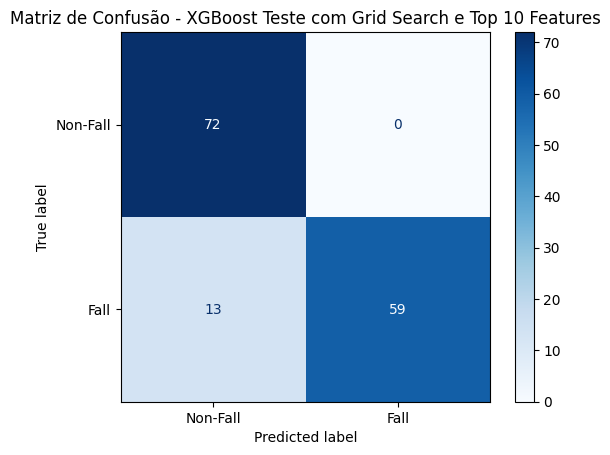

✅ Acurácia no conjunto de teste (XGBoost com Grid Search e Top 10 Features): 0.9097
✅ Acurácia no conjunto de treino (XGBoost com Grid Search e Top 10 Features): 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py", line 1640, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Exp

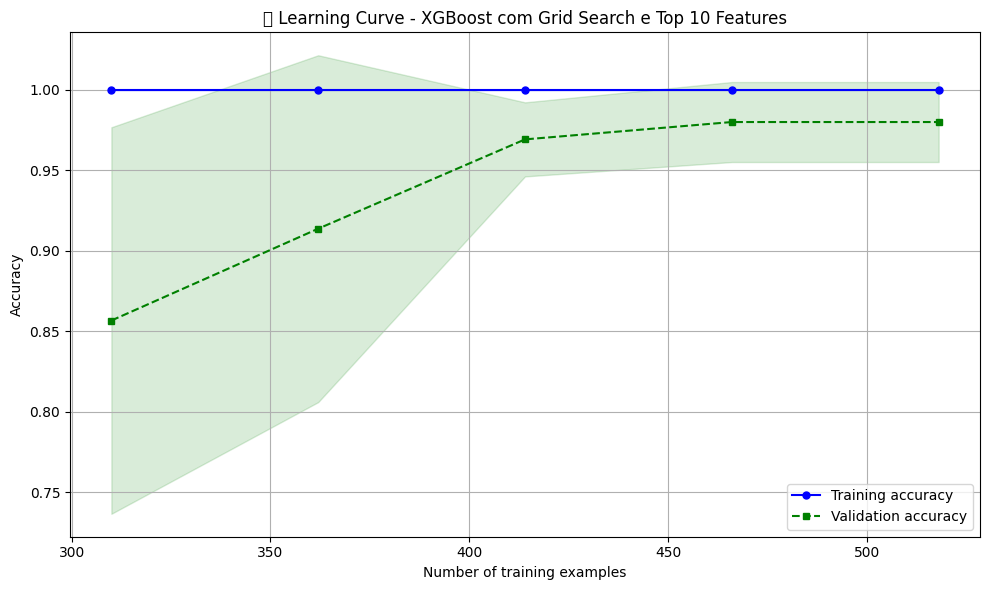

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, learning_curve
import pandas as pd
import numpy as np

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# === FIRST GRID SEARCH (Full Feature Set) ===
print("Performing Grid Search on the full feature set...")
grid_search_xgb_full = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb_full.fit(X, y)

best_xgb_model_full = grid_search_xgb_full.best_estimator_
print(f"\n✅ Melhor combinação de hiperparâmetros para XGBoost (Full Features):")
print(grid_search_xgb_full.best_params_)

# Get feature importances from the best model on the full set
importances_xgb_full = best_xgb_model_full.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feat_importance_df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_xgb_full
}).sort_values(by='Importance', ascending=False)

print("\n📊 Feature Importance (XGBoost - Full Features):")
print(feat_importance_df_xgb.head(30))

# Select the top 10 features
top_10_features = feat_importance_df_xgb['Feature'].head(30).tolist()

# Filter the training and testing data to include only the top 10 features
X_top_10 = X[top_10_features]
X_test_top_10 = X_test[top_10_features]

# === SECOND GRID SEARCH (Top 10 Features) ===
print("\nPerforming Grid Search on the top 10 features...")
grid_search_xgb_top_10 = GridSearchCV(
    estimator=xgb_model,  # Use a fresh model instance for the second grid search
    param_grid=param_grid_xgb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_xgb_top_10.fit(X_top_10, y)

best_xgb_model_top_10 = grid_search_xgb_top_10.best_estimator_
print(f"\n✅ Melhor combinação de hiperparâmetros para XGBoost (Top 10 Features):")
print(grid_search_xgb_top_10.best_params_)

# === Evaluation with the best model from the second grid search (Top 10 Features) ===
print("\nEvaluating the best model with Top 10 Features...")

# Predict on the training set using the best model from the second grid search
y_train_pred_xgb_top_10 = best_xgb_model_top_10.predict(X_top_10)

# Evaluate the best model on the training set
print("\n📄 Classification Report (XGBoost - treino com Grid Search e Top 10 Features):")
print(classification_report(y, y_train_pred_xgb_top_10))

# Predict on the test set using the best model from the second grid search
y_test_pred_xgb_top_10 = best_xgb_model_top_10.predict(X_test_top_10)

# Evaluate the best model on the test set
print("\n📄 Classification Report (XGBoost - teste final com Grid Search e Top 10 Features):")
print(classification_report(y_test, y_test_pred_xgb_top_10))

# Confusion Matrix for the best model
cm_xgb_top_10 = confusion_matrix(y_test, y_test_pred_xgb_top_10)
disp_xgb_top_10 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_top_10, display_labels=['Non-Fall', 'Fall'])
disp_xgb_top_10.plot(cmap='Blues')
plt.title('Matriz de Confusão - XGBoost Teste com Grid Search e Top 10 Features')
plt.grid(False)
plt.show()

# Accuracy for the best model on test set
acc_xgb_top_10 = accuracy_score(y_test, y_test_pred_xgb_top_10)
print(f"✅ Acurácia no conjunto de teste (XGBoost com Grid Search e Top 10 Features): {acc_xgb_top_10:.4f}")

# Accuracy for the best model on training set
acc_train_xgb_top_10 = accuracy_score(y, y_train_pred_xgb_top_10)
print(f"✅ Acurácia no conjunto de treino (XGBoost com Grid Search e Top 10 Features): {acc_train_xgb_top_10:.4f}")

# Calculate and plot learning curve for the best model on top 10 features
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_xgb_model_top_10,
    X=X_top_10,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('🎯 Learning Curve - XGBoost com Grid Search e Top 10 Features')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Performing Grid Search on the full feature set (SVM)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Melhor combinação de hiperparâmetros para SVM (Full Features):
{'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Evaluating the best model with Full Features (SVM)...

📄 Classification Report (SVM - treino com Grid Search e Full Features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       1.00      1.00      1.00       324

    accuracy                           1.00       648
   macro avg       1.00      1.00      1.00       648
weighted avg       1.00      1.00      1.00       648


📄 Classification Report (SVM - teste final com Grid Search e Full Features):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        72
           1       1.00      0.82      0.90        72

    accuracy                           0.91       144
   ma

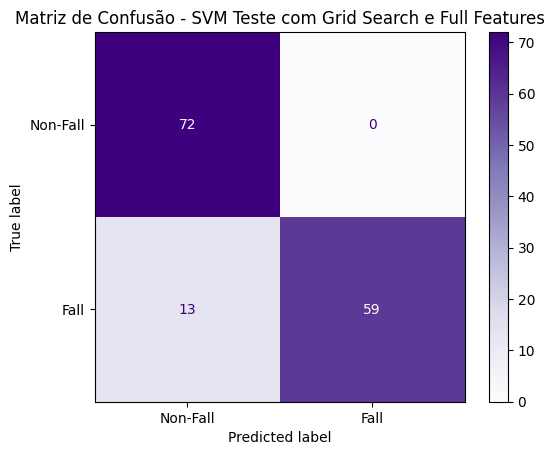

✅ Acurácia no conjunto de teste (SVM com Grid Search e Full Features): 0.9097
✅ Acurácia no conjunto de treino (SVM com Grid Search e Full Features): 1.0000

Calculating Learning Curve for the best model on Full Features (SVM)...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

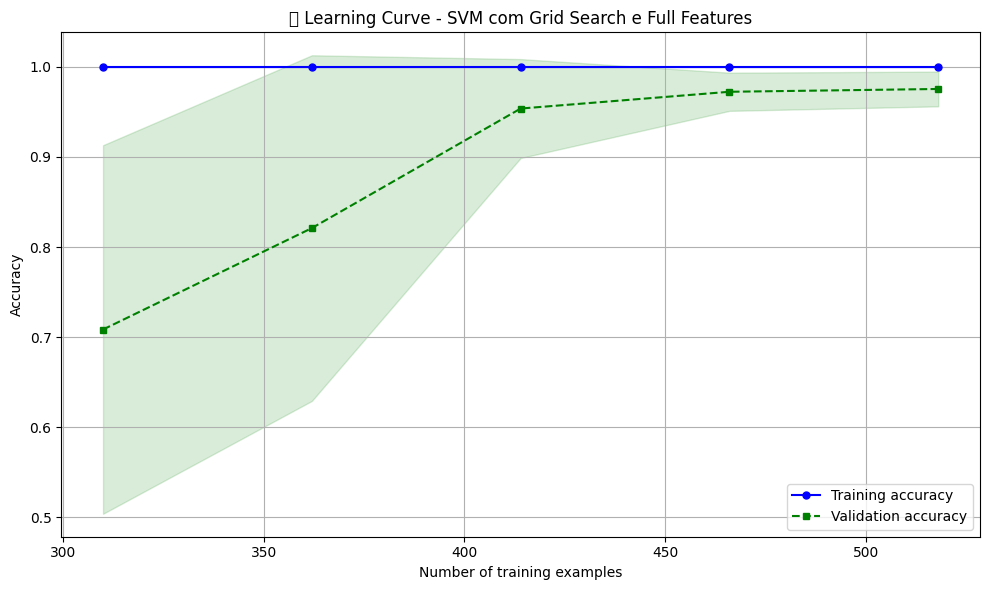

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, GridSearchCV
import pandas as pd # Import pandas for feature importance dataframe

# Create a pipeline with scaler and SVM
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(random_state=42) # Removed initial parameters to be tuned by GridSearchCV
)

# Define the hyperparameter grid for SVM
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.1, 1],
    'svc__kernel': ['rbf', 'linear']
}

# === FIRST GRID SEARCH (Full Feature Set) ===
print("Performing Grid Search on the full feature set (SVM)...")
grid_search_svm_full = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_svm_full.fit(X, y)

best_svm_model_full = grid_search_svm_full.best_estimator_
print(f"\n✅ Melhor combinação de hiperparâmetros para SVM (Full Features):")
print(grid_search_svm_full.best_params_)

# Note: SVM models from scikit-learn do not directly provide feature importances
# like tree-based models (Random Forest, XGBoost).
# We will proceed with evaluation using the best model from the full feature set
# and then the best model from a grid search on the top features (identified by another model if desired,
# but here we will just use the best model from the full set for subsequent evaluation on top features).

# === Evaluation with the best model from the first grid search (Full Feature Set) ===
print("\nEvaluating the best model with Full Features (SVM)...")

# Predict on the training set using the best model from the first grid search
y_train_pred_svm_full = best_svm_model_full.predict(X)

# Evaluate the best model on the training set
print("\n📄 Classification Report (SVM - treino com Grid Search e Full Features):")
print(classification_report(y, y_train_pred_svm_full))

# Predict on the test set using the best model from the first grid search
y_test_pred_svm_full = best_svm_model_full.predict(X_test)

# Evaluate the best model on the test set
print("\n📄 Classification Report (SVM - teste final com Grid Search e Full Features):")
print(classification_report(y_test, y_test_pred_svm_full))

# Confusion Matrix for the best model (Full Features)
cm_svm_full = confusion_matrix(y_test, y_test_pred_svm_full)
disp_svm_full = ConfusionMatrixDisplay(confusion_matrix=cm_svm_full, display_labels=['Non-Fall', 'Fall'])
disp_svm_full.plot(cmap='Purples')
plt.title('Matriz de Confusão - SVM Teste com Grid Search e Full Features')
plt.grid(False)
plt.show()

# Accuracy for the best model on test set (Full Features)
acc_svm_full = accuracy_score(y_test, y_test_pred_svm_full)
print(f"✅ Acurácia no conjunto de teste (SVM com Grid Search e Full Features): {acc_svm_full:.4f}")

# Accuracy for the best model on training set (Full Features)
acc_train_svm_full = accuracy_score(y, y_train_pred_svm_full)
print(f"✅ Acurácia no conjunto de treino (SVM com Grid Search e Full Features): {acc_train_svm_full:.4f}")


# === Learning Curve for the best model on Full Features ===
print("\nCalculating Learning Curve for the best model on Full Features (SVM)...")
train_sizes_svm_full, train_scores_svm_full, test_scores_svm_full = learning_curve(
    estimator=best_svm_model_full,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean_svm_full = np.mean(train_scores_svm_full, axis=1)
train_std_svm_full = np.std(train_scores_svm_full, axis=1)
test_mean_svm_full = np.mean(test_scores_svm_full, axis=1)
test_std_svm_full = np.std(test_scores_svm_full, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_svm_full, train_mean_svm_full, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes_svm_full, train_mean_svm_full - train_std_svm_full, train_mean_svm_full + train_std_svm_full, alpha=0.15, color='blue')

plt.plot(train_sizes_svm_full, test_mean_svm_full, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes_svm_full, test_mean_svm_full - test_std_svm_full, test_mean_svm_full + test_std_svm_full, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('🎯 Learning Curve - SVM com Grid Search e Full Features')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Since SVM doesn't have built-in feature importance, we cannot select top 10 features based on SVM itself.
# If you have feature importances from another model (like XGBoost or Random Forest),
# you could filter X and X_test based on those top features and then train/evaluate SVM
# on that reduced set. For now, we will skip the "top 10 features" part for SVM
# unless the user provides a specific set of top features to use.

Performing Grid Search on the full feature set (Random Forest)...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Melhor combinação de hiperparâmetros para Random Forest (Full Features):
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

📊 Feature Importance (Random Forest - Full Features):
               Feature  Importance
42          acc_z_peak    0.166809
23          gyro_z_std    0.100064
41  gyro_magnitude_std    0.094589
39           acc_t_max    0.061364
11           acc_z_std    0.057020
2            acc_x_min    0.044911
0           acc_x_mean    0.036595
9            acc_z_max    0.033500
15          gyro_x_std    0.031977
33           mag_z_max    0.030810
19          gyro_y_std    0.029714
4           acc_y_mean    0.024990
1            acc_x_max    0.024332
20         gyro_z_mean    0.022705
6            acc_y_min    0.021224
8           acc_z_mean    0.018740
32          mag_z_mean    0.018419


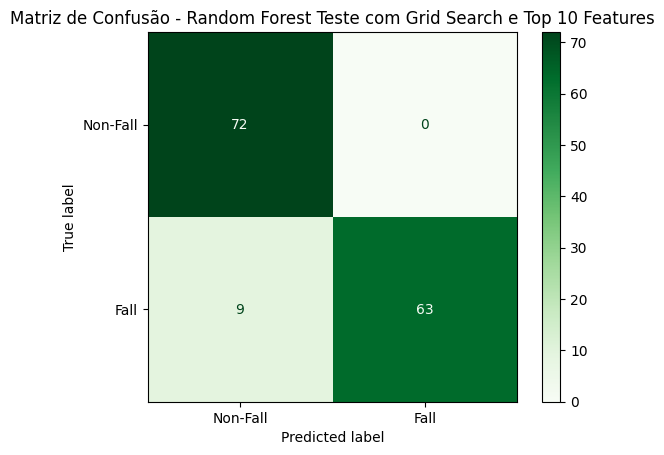

✅ Acurácia no conjunto de teste (Random Forest com Grid Search e Top 10 Features): 0.9375
✅ Acurácia no conjunto de treino (Random Forest com Grid Search e Top 10 Features): 1.0000


/tmp/ipython-input-131-874664193.py:136: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


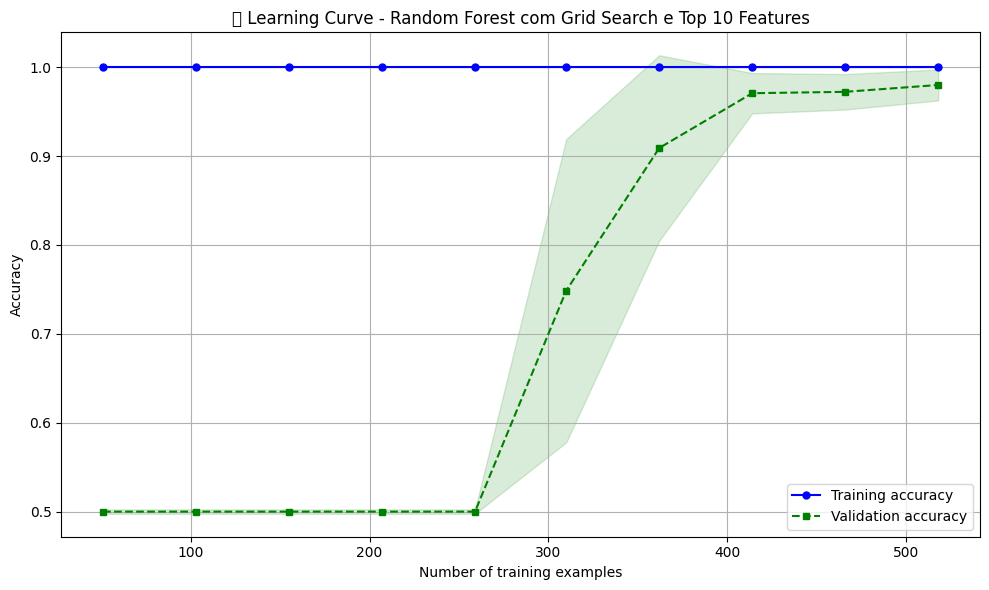

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, learning_curve
import pandas as pd
import numpy as np

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],

}



# === FIRST GRID SEARCH (Full Feature Set) ===
print("Performing Grid Search on the full feature set (Random Forest)...")
grid_search_rf_full = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_rf_full.fit(X, y)

best_rf_model_full = grid_search_rf_full.best_estimator_
print(f"\n✅ Melhor combinação de hiperparâmetros para Random Forest (Full Features):")
print(grid_search_rf_full.best_params_)

# Get feature importances from the best model on the full set
importances_rf_full = best_rf_model_full.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feat_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_rf_full
}).sort_values(by='Importance', ascending=False)

print("\n📊 Feature Importance (Random Forest - Full Features):")
print(feat_importance_df_rf.head(28))

# Select the top 10 features
top_10_features_rf = feat_importance_df_rf['Feature'].head(28).tolist()

# Filter the training and testing data to include only the top 10 features
X_top_10_rf = X[top_10_features_rf]
X_test_top_10_rf = X_test[top_10_features_rf]

# === SECOND GRID SEARCH (Top 10 Features) ===
print("\nPerforming Grid Search on the top 10 features (Random Forest)...")
grid_search_rf_top_10 = GridSearchCV(
    estimator=rf_model,  # Use a fresh model instance for the second grid search
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)
grid_search_rf_top_10.fit(X_top_10_rf, y)

best_rf_model_top_10 = grid_search_rf_top_10.best_estimator_
print(f"\n✅ Melhor combinação de hiperparâmetros para Random Forest (Top 10 Features):")
print(grid_search_rf_top_10.best_params_)

# === Evaluation with the best model from the second grid search (Top 10 Features) ===
print("\nEvaluating the best model with Top 10 Features (Random Forest)...")

# Predict on the training set using the best model from the second grid search
y_train_pred_rf_top_10 = best_rf_model_top_10.predict(X_top_10_rf)

# Evaluate the best model on the training set
print("\n📄 Classification Report (Random Forest - treino com Grid Search e Top 10 Features):")
print(classification_report(y, y_train_pred_rf_top_10))

# Predict on the test set using the best model from the second grid search
y_test_pred_rf_top_10 = best_rf_model_top_10.predict(X_test_top_10_rf)

# Evaluate the best model on the test set
print("\n📄 Classification Report (Random Forest - teste final com Grid Search e Top 10 Features):")
print(classification_report(y_test, y_test_pred_rf_top_10))

# Confusion Matrix for the best model
cm_rf_top_10 = confusion_matrix(y_test, y_test_pred_rf_top_10)
disp_rf_top_10 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_top_10, display_labels=['Non-Fall', 'Fall'])
disp_rf_top_10.plot(cmap='Greens')
plt.title('Matriz de Confusão - Random Forest Teste com Grid Search e Top 10 Features')
plt.grid(False)
plt.show()

# Accuracy for the best model on test set
acc_rf_top_10 = accuracy_score(y_test, y_test_pred_rf_top_10)
print(f"✅ Acurácia no conjunto de teste (Random Forest com Grid Search e Top 10 Features): {acc_rf_top_10:.4f}")

# Accuracy for the best model on training set
acc_train_rf_top_10 = accuracy_score(y, y_train_pred_rf_top_10)
print(f"✅ Acurácia no conjunto de treino (Random Forest com Grid Search e Top 10 Features): {acc_train_rf_top_10:.4f}")

# Calculate and plot learning curve for the best model on top 10 features
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    estimator=best_rf_model_top_10,
    X=X_top_10_rf,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
test_mean_rf = np.mean(test_scores_rf, axis=1)
test_std_rf = np.std(test_scores_rf, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_rf, train_mean_rf, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, alpha=0.15, color='blue')

plt.plot(train_sizes_rf, test_mean_rf, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes_rf, test_mean_rf - test_std_rf, test_mean_rf + test_std_rf, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('🎯 Learning Curve - Random Forest com Grid Search e Top 10 Features')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()